# Introduction

*   This notebook implements the "Q-learning" algorithm for the "CartPole-v0" environment. For more information on the environment, please visit [here](https://gym.openai.com/envs/CartPole-v0/#barto83). Also, check the related paper [here](https://ieeexplore.ieee.org/document/6313077).



*   The algorithm and the related text is copied and pasted from Section 6.5 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition).



*   You can download the book [here](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf).

# Q-learning: Off-policy TD Control

One of the early breakthroughs in reinforcement learning was the development of an off-policy TD control algorithm known as *Q-learning* ([Watkins, 1989](http://www.cs.rhul.ac.uk/~chrisw/thesis.html)), defined by

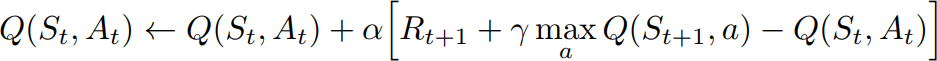

In this case, the learned action-value function, $Q$, directly approximates $q_{*}$, the optimal action-value function, independent of the policy being followed. This dramatically simplifies the analysis of the algorithm and enabled early convergence proofs. The policy still has an effect in that it determines which state–action pairs are visited and updated. However, all that is required for correct convergence is that all pairs continue to be updated. This is a minimal requirement in the sense that any method guaranteed to find optimal behavior in the general case must require it. Under this assumption and a variant of the usual stochastic approximation conditions on the sequence of step-size parameters, $Q$ has been shown to converge with probability $1$ to $q_{*}$.

**Algorithm**

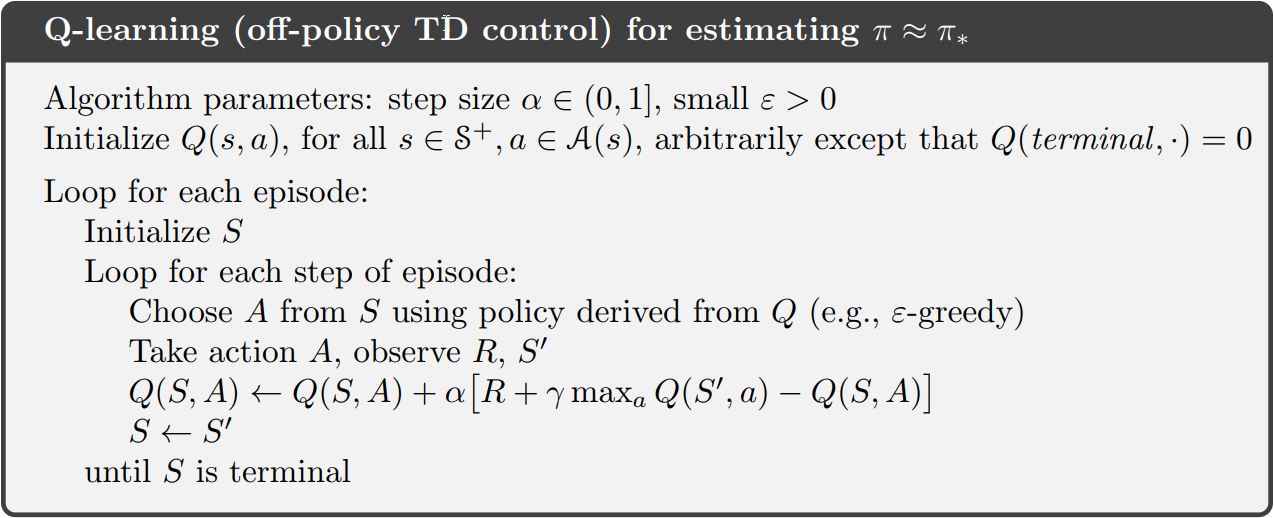

# Python Implementation

**Import Packages**

In [ ]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

**Q-learning Agent**

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space, num_actions):

        self.alpha = alpha  # step-size parameter
        self.epsilon = epsilon  # probability of taking a random action in an ε-greedy policy
        self.gamma = gamma  # discount-rate parameter (discount factor)
        self.state_space = state_space
        self.action_space = action_space
        self.num_actions = num_actions

        self.Q = {}
        for s in self.state_space:
            for a in range(self.num_actions):
                self.Q[s, a] = 0

    def policy(self, state):
        """
        Implement the ε-greedy action selection policy.
        """

        q_values = np.array([self.Q[state, a] for a in range(self.num_actions)])
        r = np.random.random()

        if r < self.epsilon:
            action = self.action_space.sample()  # random action - exploration
        else:
            action = np.argmax(q_values)  # greedy action - exploitation

        return action

    def update_values(self, state, action, reward, state_):
        """
        Update the action-value estimates.
        """

        max_q_value = np.max(np.array([self.Q[state_, a] for a in range(self.num_actions)]))
        delta = reward + self.gamma * max_q_value - self.Q[state, action]  # TD error
        self.Q[state, action] += self.alpha * delta

    def decrement_epsilon(self, episodes):
        """
        Decrease the value of ε after each episode.
        **Usage is optional.**
        """

        # This is to decrease the probability of taking a random action and ensure convergence with ε-greedy policies.
        # This is because as the action-value estimates change toward the optimal values, the need for exploration
        # decreases and more exploitation is needed.

        if self.epsilon > 0:
            self.epsilon -= 1 / episodes
        else:
            self.epsilon = 0

**Main Body**

In [ ]:
env = gym.make("CartPole-v0")
action_space = env.action_space  # Discrete(2) = [0, 1]
num_actions = 2
# print(env.observation_space.high)
# print(env.observation_space.low)

cart_position_bins = np.linspace(-2.4, 2.4, 19)  # 20 bins/buckets - [-2.4m 2.4m]
cart_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
pole_angle_bins = np.linspace(-12 * math.pi / 180, 12 * math.pi / 180, 19)  # 20 bins/buckets - [-12° 12°]
pole_angular_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
state_bins = [cart_position_bins, cart_velocity_bins, pole_angle_bins, pole_angular_velocity_bins]

state_space = []
for s1 in range(len(cart_position_bins) + 1):
    for s2 in range(len(cart_position_bins) + 1):
        for s3 in range(len(cart_position_bins) + 1):
            for s4 in range(len(cart_position_bins) + 1):
                state_space.append((s1, s2, s3, s4))


def discretize_obs_space(obs, bins):
    """
    Discretize the continuous observation space.
    """

    cart_position, cart_velocity, pole_angle, pole_angular_velocity = obs

    cart_position = int(np.digitize(cart_position, bins[0], right=False))
    cart_velocity = int(np.digitize(cart_velocity, bins[1], right=False))
    pole_angle = int(np.digitize(pole_angle, bins[2], right=False))
    pole_angular_velocity = int(np.digitize(pole_angular_velocity, bins[3], right=False))

    return cart_position, cart_velocity, pole_angle, pole_angular_velocity


alpha = 0.1  # step-size parameter
epsilon = 1.0  # probability of taking a random action in an ε-greedy policy
gamma = 0.99  # discount-rate parameter (discount factor)

agent = Agent(alpha, epsilon, gamma, state_space, action_space, num_actions)

episodes = 50000
total_rewards = []

for episode in range(1, episodes + 1):

    observation = env.reset()
    state = discretize_obs_space(observation, state_bins)
    done = False

    total_reward = 0
    steps = 0
    # actions = []

    while not done:

        # env.render()
        action = agent.policy(state)
        observation_, reward, done, info = env.step(action)
        state_ = discretize_obs_space(observation_, state_bins)
        agent.update_values(state, action, reward, state_)
        state = state_

        total_reward += reward
        steps += 1
        # actions.append(action)

    agent.decrement_epsilon(episodes)
    total_rewards.append(total_reward)

    if episode % 1000 == 0:
        print(f"============ Episode: {episode} ============")
        print(f"Total Reward: {total_reward}")
        print(f"Steps: {steps}")
        # print(f"Actions: {actions}")

# env.close()

**Plot**

In [ ]:
x_axis = [i for i in range(1, episodes + 1)]
y_axis = total_rewards

plt.figure(figsize=(12, 6), dpi=100)

plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.plot(x_axis, y_axis)
plt.grid()
plt.show()

**Simulation Results**

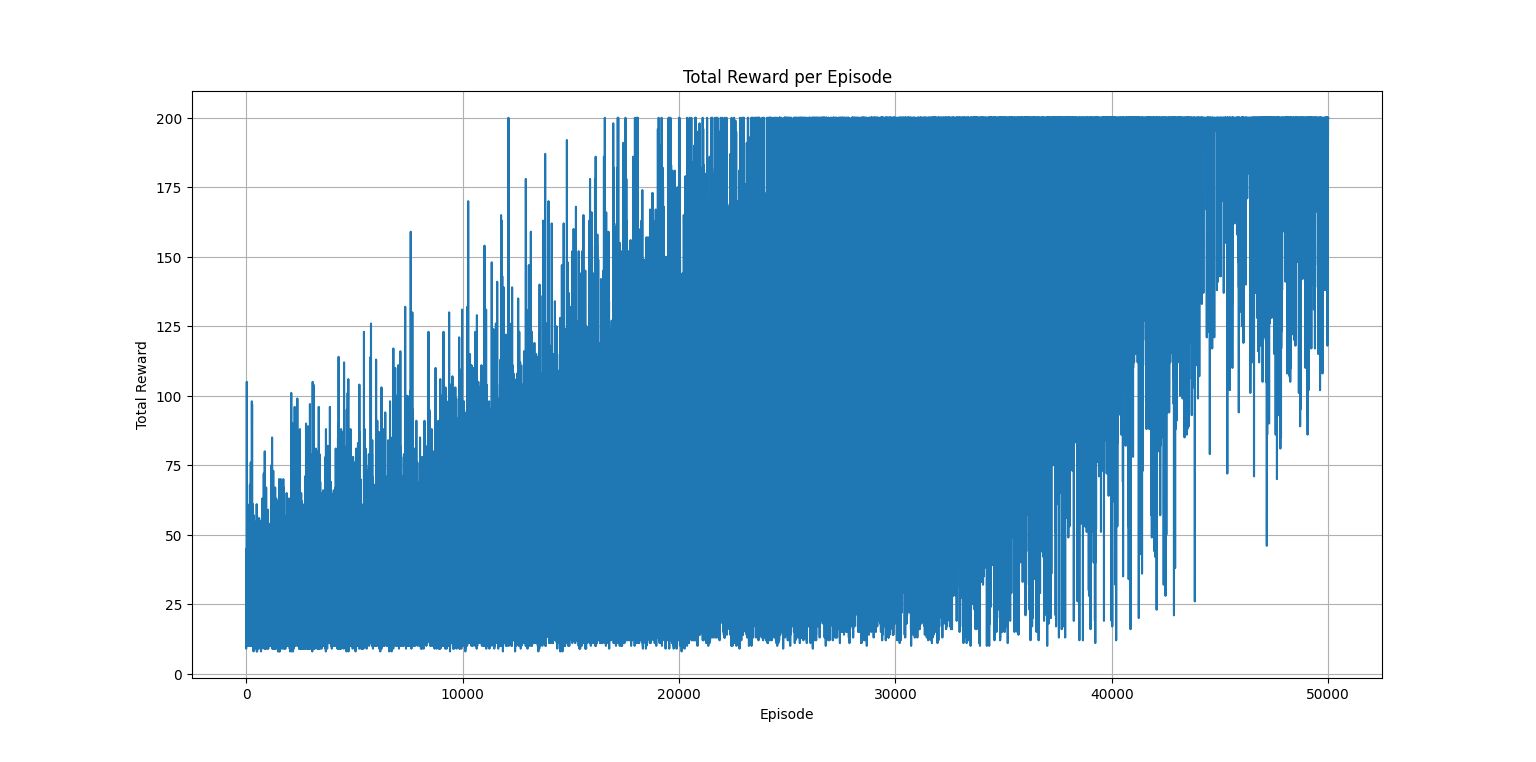